#Content Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset, Dataset
import operator

import pickle
import tqdm

import os
import random

# Data Loader

In [ ]:
POSITIVE_SENTIMENT = 1.
NEGATIVE_SENTIMENT = 0.
NEUTRAL_SENTIMENT = -1.


SENTIMENT_NAMES = {
    POSITIVE_SENTIMENT: "Positive",
    NEUTRAL_SENTIMENT: "Neutral",
    NEGATIVE_SENTIMENT: "Negative"
}
# file located in drive
SENTS_PATH = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/SOStr.txt'
TREES_PATH = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/STree.txt'
DICT_PATH = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/dictionary.txt'
LABELS_path = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/sentiment_labels.txt'


def get_sentiment_class_from_val(sentiment_val: float):
    if sentiment_val <= 0.4:
        return NEGATIVE_SENTIMENT
    elif sentiment_val >= 0.6:
        return POSITIVE_SENTIMENT
    else:
        return NEUTRAL_SENTIMENT

class SentimentTreeNode(object):
    def __init__(self, text: list, sentiment_val: float, min_token_idx: int, children=[], parent=None):
        self.text = text
        self.sentiment_val = sentiment_val
        self.min_token_idx = min_token_idx
        self.sentiment_class = get_sentiment_class_from_val(sentiment_val)
        self.children = children
        self.parent = parent


class Sentence(object):
    """
    Represents a sentence in sentiment tree bank.
    You can access the sentence text by sent.text
    This will give you a list of tokens (strings) in the order that they appear in the sentence.
    sent.sentiment_class is the coding of the annotated sentiment polarity of the sentence.
    sent.sentiment_val is the exact annotated sentiment value in the range [0,1]
    """
    def __init__(self, sentence_root: SentimentTreeNode):
        self.root = sentence_root
        self.text = sentence_root.text
        self.sentiment_class = sentence_root.sentiment_class
        self.sentiment_val = sentence_root.sentiment_val

    def _get_leaves_recursively(self, cur_root):
        if len(cur_root.children) == 0:
            return [cur_root]
        else:
            cur_leaves = []
            for child in cur_root.children:
                cur_leaves += self._get_leaves_recursively(child)
            return cur_leaves

    def get_leaves(self):
        return self._get_leaves_recursively(self.root)

    def __repr__(self):
        return " ".join(self.text) + " | " + SENTIMENT_NAMES[self.sentiment_class] + " | " + str(self.sentiment_val)


class SentimentTreeBank(object):
    """
    The main object that represents the stanfordSentimentTreeBank dataset. Can be used to access the
    examples and some other utilities.
    """
    def __init__(self, path="stanfordSentimentTreebank", split_ratios=(0.8,0.1,0.1), split_words=True):
        """

        :param path: relative or absolute path to the datset directory
        :param split_ratios: split ratios for train, validation and test. please do not change!
        :param split_words: whether to split tokens with "-" and "/" symbols. please do not change!
        """
        self._base_path = path
        self.split_words = split_words
        sentences = self._read_sentences()
        self.sentences = self._build_dataset(sentences)
        if self.split_words:
            for sent in self.sentences:
                leaves = sent.get_leaves()
                for node in leaves:
                    node_text = node.text
                    splitted = node_text[0].split("-")
                    splitted_final = []
                    for s in splitted:
                        splitted_final.extend(s.split("\\/"))
                    if len(splitted_final) > 1 and all([len(s) > 0 for s in splitted_final]):
                        leaves = [SentimentTreeNode([s], node.sentiment_val,
                                                    min_token_idx=node.min_token_idx, parent=node) for
                                  s in splitted_final]
                        node.text = splitted_final
                        node.children = leaves
                        cur_parent = node.parent
                        while cur_parent != None:
                            cur_parent.text = []
                            for child in cur_parent.children:
                                cur_parent.text.extend(child.text)
                            cur_parent = cur_parent.parent
                sent.text = sent.root.text


        assert len(split_ratios) == 3
        assert sum(split_ratios) == 1
        self.split_ratios = split_ratios



    def _read_sentences(self):
        sentences = []
        with open(os.path.join(self._base_path, SENTS_PATH), "r", encoding="utf-8") as f:
            lines = f.read().split("\n")
            for i, line in enumerate(lines):
                if len(line.strip()) == 0:
                    continue
                line_content = line.strip()
                tokens = line_content.split("|")
                tokens = [t.lower().replace("-lrb-","(").replace("-rrb-", ")") for t in tokens]
                sentences.append(tokens)
        return sentences

    def _build_dataset(self, sentences):
        phrases_dictionary = {}

        # extract phrases
        with open(os.path.join(self._base_path, DICT_PATH), "r", encoding="utf-8") as f:
            lines = f.read().split("\n")[:-1]
            for line in lines:
                phrase, phrase_id = line.strip().split("|")
                phrases_dictionary[phrase.lower().replace("-lrb-","(").replace("-rrb-", ")")] = int(phrase_id)

        # extract labels
        with open(os.path.join(self._base_path, LABELS_path), "r",  encoding="utf-8") as f:
            lines = [l.strip().split("|") for l in f.read().split("\n")[1:-1]]
            labels_dict = {int(l[0]): float(l[1]) for l in lines}


        def get_val_from_phrase(phrase_tokens_list):
            try:
                return labels_dict[phrases_dictionary[" ".join(phrase_tokens_list)]]
            except:
                print("couldn't find key!")

        # load the sentences tree structures
        tree_pointers = []
        with open(os.path.join(self._base_path, TREES_PATH), "r") as f:
            for line in f.readlines():
                sent_pointers = [int(p) for p in line.strip().split("|")]
                tree_pointers.append(sent_pointers)
        assert len(tree_pointers) == len(sentences)

        # create Sentence instances with tree of SentimentTreeNodes
        labeled_sentences = []
        for sent, sent_pointers in zip(sentences, tree_pointers):
            try:

                children_dict = {i: [] for i in range(len(sent_pointers))}
                for i, p in enumerate(sent_pointers):
                    if i < len(sent):
                        node_text = [sent[i]]
                        node = SentimentTreeNode(text=node_text, sentiment_val=get_val_from_phrase(node_text),
                                                 min_token_idx=i)
                    else:
                        children = children_dict[i]
                        children = sorted(children, key= lambda n: n.min_token_idx)
                        node_text = []
                        for child in children:
                            node_text.extend(child.text)
                        node = SentimentTreeNode(text=node_text, sentiment_val=get_val_from_phrase(node_text),
                                                 children=children, min_token_idx=children[0].min_token_idx)
                        for child in children:
                            child.parent = node
                    if p > 0:
                        children_dict[p - 1].append(node)
                    last_node = node
                new_sentence = Sentence(last_node)
                if new_sentence.sentiment_class == NEUTRAL_SENTIMENT:
                    continue
                labeled_sentences.append(new_sentence)
            except Exception as e:
                raise e
                print("couldn't parse sentence!")
                print(sent)
        random.Random(1).shuffle(labeled_sentences) # shuffle but with the same shuffle each time
        return labeled_sentences

    def get_train_set(self):
        """
        :return: list of Sentence instances for the train part of the dataset
        """
        if not hasattr(self, "_train_set"):
            self._train_set = self.sentences[:int(self.split_ratios[0] * len(self.sentences))]
        return self._train_set

    def _extract_all_phrases(self, root):
        phrases = [Sentence(root)] if root.sentiment_class != NEUTRAL_SENTIMENT else []
        if len(root.text) == 1:
            return []
        for child in root.children:
            phrases += self._extract_all_phrases(child)
        return phrases

    def get_train_set_phrases(self):
        """
        :return: list of Sentence instances for the train part of the dataset including all sub-phrases
        """
        if not hasattr(self, "_train_set_phrases"):
            train_set = self.get_train_set()
            train_set_phrases = []
            for sent in train_set:
                train_set_phrases += self._extract_all_phrases(sent.root)
            self._train_set_phrases = train_set_phrases
        return self._train_set_phrases

    def get_test_set(self):
        """
        :return: list of Sentence instances for the test part of the dataset
        """
        if not hasattr(self, "_test_set"):
            begin_index = int(self.split_ratios[0] * len(self.sentences))
            end_index = int(sum(self.split_ratios[:2]) * len(self.sentences))
            self._test_set = self.sentences[begin_index:end_index]
        return self._test_set

    def get_validation_set(self):
        """
        :return: list of Sentence instances for the validation part of the dataset
        """
        if not hasattr(self, "_validation_set"):
            self._validation_set = self.sentences[int(sum(self.split_ratios[:2]) * len(self.sentences)):]
        return self._validation_set

    def get_train_word_counts(self):
        """
        :return: dictionary of all words in the train set with their frequency in the train set.
        """
        if not hasattr(self, "_train_word_counts"):
            word_counts = {}
            for sent in self.get_train_set():
                for word_node in sent.get_leaves():
                    assert len(word_node.text) == 1
                    word_text = word_node.text[0]
                    if word_text in word_counts:
                        word_counts[word_text] += 1
                    else:
                        word_counts[word_text] = 1
            self._train_word_counts = word_counts

        return self._train_word_counts

    def get_word_counts(self):
        """
        :return: dictionary of all words in the dataset with their frequency in the whole dataset.
        """
        if not hasattr(self, "_word_counts"):
            word_counts = {}
            for sent in self.sentences:
                for word_node in sent.get_leaves():
                    assert len(word_node.text) == 1
                    word_text = word_node.text[0]
                    if word_text in word_counts:
                        word_counts[word_text] += 1
                    else:
                        word_counts[word_text] = 1
            self._word_counts = word_counts

        return self._word_counts



def get_negated_polarity_examples(sentences_list, num_examples=None, choose_random=False):
    """
    Returns the indices of the sentences in sentences_list which have subphrase in the second level with
    sentiment polarity different than the whole sentence polarity.
    :param sentences_list: list of Sentence objects
    :param num_examples: number of examples to return, if None all of them are returned
    :param choose_random: relevant only if num_examples is lower than the number of exisitng negated
    polarity examples in sentences_list
    """

    if num_examples is None:
        num_examples = len(sentences_list) # take all possible sentences

    def is_polarized(sent: Sentence):
        if sent.sentiment_class == NEUTRAL_SENTIMENT:
            return False
        else:
            root_polarity = sent.sentiment_class
            for child in sent.root.children:
                if child.sentiment_class == 1 - root_polarity:
                    return True
            return False
    indexed_senteces = list(enumerate(sentences_list))
    negated_sentences = list(filter(lambda s: is_polarized(s[1]), indexed_senteces))
    negated_sentences_indices = [i for i,s in negated_sentences]
    if len(negated_sentences) <= num_examples:
        return negated_sentences_indices
    else:
        if choose_random:
            random.shuffle(negated_sentences_indices)
        return negated_sentences_indices[:num_examples]


def get_sentiment_words(sent: Sentence):
    sent_polarity = sent.sentiment_class
    return [node for node in sent.get_leaves() if node.sentiment_class == sent_polarity]


def get_rare_words_examples(sentences_list, dataset: SentimentTreeBank,
                            num_sentences=50):
    """
    Computes for each sentence in sentences the maximal train frequency of sentiment word, where sentiment
    word is a word which is labeled with either positive or negative sentiment value, and returns the
    indices of the <num_sentences> sentences with lowest value.
    :param sentences_list: list of Sentence objects
    :param dataset: the SentimentTreebank datset object
    :param num_sentences: number of sentences to return
    :return: list of ints representing the indices of the chosen sentences out of the input sentences_list
    """
    word_counts = dataset.get_train_word_counts()

    def get_count(word_node: SentimentTreeNode):
        word_text = word_node.text[0]
        if word_text in word_counts:
            return word_counts[word_text]
        else:
            return 0
    indexed_sentences = list(enumerate(sentences_list))
    indexed_sentences = list(filter(lambda s: len(get_sentiment_words(s[1])) > 0, indexed_sentences))
    indexed_sentences = sorted(indexed_sentences, key= lambda s: max([get_count(node) for node in
                                                                      get_sentiment_words(s[1])]))
    indices = [i for i,s in indexed_sentences]
    return indices[:num_sentences]




if __name__ == '__main__':
    # examples for reading the sentiment dataset
    dataset = SentimentTreeBank()
    # get train set
    print(dataset.get_train_set()[:2])
    print(dataset.get_train_set()[0].sentiment_val)
    # get word counts dictionary
    print(list(dataset.get_word_counts().keys())[:10])


[just too silly and sophomoric to ensnare its target audience . | Negative | 0.29167, there is n't one moment in the film that surprises or delights . | Negative | 0.16667]
0.29167
['just', 'too', 'silly', 'and', 'sophomoric', 'to', 'ensnare', 'its', 'target', 'audience']


# Exercise Blanks

## Constants

In [ ]:
SEQ_LEN = 52
# SEQ_LEN = 64

W2V_EMBEDDING_DIM = 300

ONEHOT_AVERAGE = "onehot_average"
W2V_AVERAGE = "w2v_average"
W2V_SEQUENCE = "w2v_sequence"

TRAIN = "train"
VAL = "val"
TEST = "test"

## Helper methods and classes

In [ ]:
def get_available_device():
    """
    Allows training on GPU if available. Can help with running things faster when a GPU with cuda is
    available but not a most...
    Given a device, one can use module.to(device)
    and criterion.to(device) so that all the computations will be done on the GPU.
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def save_model(model, path, epoch, optimizer):
    """
    Utility function for saving checkpoint of a model, so training or evaluation can be executed later on.
    :param model: torch module representing the model
    :param optimizer: torch optimizer used for training the module
    :param path: path to save the checkpoint into
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, path)


def load(model, path, optimizer):
    """
    Loads the state (weights, paramters...) of a model which was saved with save_model
    :param model: should be the same model as the one which was saved in the path
    :param path: path to the saved checkpoint
    :param optimizer: should be the same optimizer as the one which was saved in the path
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

## Data utilities

In [ ]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print(wv_from_bin.vocab[vocab[0]])
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin


def create_or_load_slim_w2v(words_list, cache_w2v=True):
    """
    returns word2vec dict only for words which appear in the dataset.
    :param words_list: list of words to use for the w2v dict
    :param cache_w2v: whether to save locally the small w2v dictionary
    :return: dictionary which maps the known words to their vectors
    """
    w2v_path = "/content/drive/MyDrive/NLP_EX_4/w2v_dict.pkl"
    if not os.path.exists(w2v_path):
        full_w2v = load_word2vec()
        w2v_emb_dict = {k: full_w2v[k] for k in words_list if k in full_w2v}
        if cache_w2v:
            save_pickle(w2v_emb_dict, w2v_path)
    else:
        w2v_emb_dict = load_pickle(w2v_path)
    return w2v_emb_dict



class OnlineDataset(Dataset):
    """
    A pytorch dataset which generates model inputs on the fly from sentences of SentimentTreeBank
    """

    def __init__(self, sent_data, sent_func, sent_func_kwargs):
        """
        :param sent_data: list of sentences from SentimentTreeBank
        :param sent_func: Function which converts a sentence to an input datapoint
        :param sent_func_kwargs: fixed keyword arguments for the state_func
        """
        self.data = sent_data
        self.sent_func = sent_func
        self.sent_func_kwargs = sent_func_kwargs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]
        sent_emb = self.sent_func(sent, **self.sent_func_kwargs)
        sent_label = sent.sentiment_class
        return sent_emb, sent_label


class DataManager():
    """
    Utility class for handling all data management task. Can be used to get iterators for training and
    evaluation.
    """

    def __init__(self, data_type=ONEHOT_AVERAGE, use_sub_phrases=True, dataset_path="stanfordSentimentTreebank", batch_size=50,
                 embedding_dim=None):
        """
        builds the data manager used for training and evaluation.
        :param data_type: one of ONEHOT_AVERAGE, W2V_AVERAGE and W2V_SEQUENCE
        :param use_sub_phrases: if true, training data will include all sub-phrases plus the full sentences
        :param dataset_path: path to the dataset directory
        :param batch_size: number of examples per batch
        :param embedding_dim: relevant only for the W2V data types.
        """

        # load the dataset
        self.sentiment_dataset = SentimentTreeBank(dataset_path, split_words=True)
        # map data splits to sentences lists
        self.sentences = {}
        if use_sub_phrases:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set_phrases()
        else:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set()

        self.sentences[VAL] = self.sentiment_dataset.get_validation_set()
        self.sentences[TEST] = self.sentiment_dataset.get_test_set()

        # map data splits to sentence input preperation functions
        words_list = list(self.sentiment_dataset.get_word_counts().keys())
        if data_type == ONEHOT_AVERAGE:
            self.sent_func = average_one_hots
            self.sent_func_kwargs = {"word_to_ind": get_word_to_ind(words_list)}
        elif data_type == W2V_SEQUENCE:
            self.sent_func = sentence_to_embedding

            self.sent_func_kwargs = {"seq_len": SEQ_LEN,
                                     "word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        elif data_type == W2V_AVERAGE:
            self.sent_func = get_w2v_average
            words_list = list(self.sentiment_dataset.get_word_counts().keys())
            self.sent_func_kwargs = {"word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        else:
            raise ValueError("invalid data_type: {}".format(data_type))
        # map data splits to torch datasets and iterators
        self.torch_datasets = {k: OnlineDataset(sentences, self.sent_func, self.sent_func_kwargs) for
                               k, sentences in self.sentences.items()}
        self.torch_iterators = {k: DataLoader(dataset, batch_size=batch_size, shuffle=k == TRAIN)
                                for k, dataset in self.torch_datasets.items()}

    def get_torch_iterator(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: torch batches iterator for this part of the datset
        """
        return self.torch_iterators[data_subset]

    def get_labels(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: numpy array with the labels of the requested part of the datset in the same order of the
        examples.
        """
        return np.array([sent.sentiment_class for sent in self.sentences[data_subset]])

    def get_input_shape(self):
        """
        :return: the shape of a single example from this dataset (only of x, ignoring y the label).
        """
        return self.torch_datasets[TRAIN][0][0].shape

In order to avoid problems of type define default type as float64 

In [ ]:
torch.set_default_dtype(torch.float64)

# Plot functions

In [ ]:
import matplotlib.pyplot as plt
def plot_results_graph(results):   
  acc_train,loss_train,acc_val,loss_val = results
  N = np.arange(0, len(acc_train))
  plt.style.use("ggplot")
  # plt.figure()
  plt.plot(N, loss_train, label="train_loss")
  plt.plot(N, loss_val, label="val_loss")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  # plt.savefig(os.path.join(model_path, "train_graph"))
  plt.show()

  plt.style.use("ggplot")
  # plt.figure()
  plt.plot(N, acc_train, label="train_acc")
  plt.plot(N, acc_val, label="val_acc")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  # plt.savefig(os.path.join(model_path, "train_graph"))
  plt.show()

# Building a simple Log-Linear model

Complete the implementation of the LogLinear class given to you. This class will
serve us to define both the simple log-linear model, and the word2vec log-linear
model. Note: although we use a sigmoid function to predict the sentiment value, it's
not necessary to operate it in the forward method. We will use a loss function that
performs the sigmoid function by itself, so be sure to implement the forward
method without it.


In [ ]:
class LogLinear(nn.Module):
    """
    general class for the log-linear models for sentiment analysis.
    """
    def __init__(self, embedding_dim):
        super(LogLinear, self).__init__()
        self.linear = nn.Linear(in_features=embedding_dim, out_features=1)

    def forward(self, x):
      layer = self.linear(x)
      return layer
      

    def predict(self, x):
      layer = self.forward(x)
      out = nn.Sigmoid()(layer)
      return out

The simple log-linear model takes the average one-hot embedding of the words in the sentence as input. A one-hot embedding of a word 𝑤 ∈ 𝑉 is a vector 𝑒 ∈ ℝ
|𝑉|
, such that 𝑒𝑖 = 1 and ∀𝑗 ∈ [|𝑉|],𝑗 ≠ 𝑖, 𝑒𝑖 = 0 (where
𝑖 is the index of 𝑤 in the vocabulary).
Therefore, in order to create a one-hot embedding, we must first assign an index to each word in the vocabulary.
Complete the 𝑔𝑒𝑡_𝑤𝑜𝑟𝑑_𝑡𝑜_𝑖𝑛𝑑(𝑤𝑜𝑟𝑑_𝑐𝑜𝑢𝑛𝑡) method. This method will be used in order to create a mapping between words in the vocabulary, and their assigned indices.

In [ ]:
def get_word_to_ind(words_list):
    """
    this function gets a list of words, and returns a mapping between
    words to their index.
    :param words_list: a list of words
    :return: the dictionary mapping words to the index
    """
    dct = {}
    for i in range(len(words_list)):
      dct[words_list[i]] = i
    return dct

After we have the index for each word in the vocabulary, we can move forward to create
the one-hot embedding for each word, and to average all the embeddings of the words
in the sentence.
Complete the following methods in order to assist you in calculating the average
one-hot embedding:
a. 𝒈𝒆𝒕_𝒐𝒏𝒆_𝒉𝒐𝒕(𝒔𝒊𝒛𝒆,𝒊𝒏𝒅)
b. 𝒂𝒗𝒆𝒓𝒂𝒈𝒆_𝒐𝒏𝒆_𝒉𝒐𝒕𝒔(𝒔𝒆𝒏𝒕,𝒘𝒐𝒓𝒅_𝒕𝒐_𝒊𝒏𝒅)


In [ ]:
import numpy as np
def get_one_hot(size, ind):
    """
    this method returns a one-hot vector of the given size, where the 1 is placed in the ind entry.
    :param size: the size of the vector
    :param ind: the entry index to turn to 1
    :return: numpy ndarray which represents the one-hot vector
    """
    one_hot_vector = np.zeros(size)
    one_hot_vector[ind] = 1
    return one_hot_vector

In [ ]:
def average_one_hots(sent, word_to_ind):
    """
    this method gets a sentence, and a mapping between words to indices, and returns the average
    one-hot embedding of the tokens in the sentence.
    :param sent: a sentence object.
    :param word_to_ind: a mapping between words to indices
    :return:
    """
    size = len(word_to_ind)
    vec = np.zeros(size)
    for word in sent.text:
      ind = word_to_ind[word]
      vec = vec + get_one_hot(size,ind)
    avg = vec / len(sent.text) 
    return avg

Implement the following methods:


1.   𝑡𝑟𝑎𝑖𝑛_𝑒𝑝𝑜𝑐ℎ(𝑚𝑜𝑑𝑒𝑙, 𝑑𝑎𝑡𝑎_𝑖𝑡𝑒𝑟𝑎𝑡𝑜𝑟 𝑜𝑝𝑡𝑖𝑚𝑖𝑧𝑒𝑟, 𝑐𝑟𝑖𝑡𝑒𝑟𝑖𝑜𝑛). This method is in
charge of running a single training epoch (epoch is a single pass over the entire
training data).
2.   𝑒𝑣𝑎𝑙𝑢𝑎𝑡𝑒(𝑚𝑜𝑑𝑒𝑙, 𝑑𝑎𝑡𝑎_𝑖𝑡𝑒𝑟𝑎𝑡𝑜𝑟, 𝑐𝑟𝑖𝑡𝑒𝑟𝑖𝑜𝑛). This method evaluates the model
on the test data it receives. Note: This method should be very similar to
𝑡𝑟𝑎𝑖𝑛_𝑒𝑝𝑜𝑐ℎ, except we don't want our model parameters to change while
we're evaluating it.
3.   𝑡𝑟𝑎𝑖𝑛_𝑚𝑜𝑑𝑒𝑙(𝑚𝑜𝑑𝑒𝑙, 𝑑𝑎𝑡𝑎_𝑚𝑎𝑛𝑎𝑔𝑒𝑟, 𝑛_𝑒𝑝𝑜𝑐ℎ𝑠, 𝑙𝑟, 𝑤𝑒𝑖𝑔ℎ𝑡_𝑑𝑒𝑐𝑎𝑦). This
method initiates the entire training process. Be sure to save the train loss and
accuracy, as well as the validation loss and accuracy, for each epoch in the
training process.
d. 𝑡𝑟𝑎𝑖𝑛_log_𝑙𝑖𝑛𝑒𝑎𝑟_𝑤𝑖𝑡ℎ_𝑜𝑛𝑒_ℎ𝑜𝑡(). This method should create all the objects
needed for the training process, and run the training process.


1. Implement the method 𝑏𝑖𝑛𝑎𝑟𝑦_𝑎𝑐𝑐𝑢𝑟𝑎𝑐𝑦(𝑝𝑟𝑒𝑑𝑠, 𝑦). This method will calculate the
accuracy of the predictions given in 𝑝𝑟𝑒𝑑𝑠, with respect to the true labels given in 𝑦.

In [ ]:
def binary_accuracy(preds, y):
    """
    This method returns tha accuracy of the predictions, relative to the labels.
    You can choose whether to use numpy arrays or tensors here.
    :param preds: a vector of predictions
    :param y: a vector of true labels
    :return: scalar value - (<number of accurate predictions> / <number of examples>)
    """
    number_of_examples = len(y)
    number_of_accurate_predictions = 0
    preds = preds[:,0]
    # if the prediction is higher than 0.5 -> it is positive, else it is negative
    new_pred = (preds > 0.5).numpy()
    for i in range(number_of_examples):
      if torch.tensor(new_pred[i]) == y[i]:  
        number_of_accurate_predictions += 1
    acc = number_of_accurate_predictions/number_of_examples
    return acc

**Note :** the loss function uses a sigmoid, therefor we shouldnt use prediction of predict (with sigmoid) for calculating the loss.
BCEWITHLOGITSLOSS Documantation :
This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

In [ ]:
def train_epoch(model, data_iterator, optimizer, criterion):
    """
    This method operates one epoch (pass over the whole train set) of training of the given model,
    and returns the accuracy and loss for this epoch
    :param model: the model we're currently training
    :param data_iterator: an iterator, iterating over the training data for the model.
    :param optimizer: the optimizer object for the training process.
    :param criterion: the criterion object for the training process.
    """

    num_of_examples = 0
    sum_acc = 0
    sum_loss = 0
    model.train()
    for x, y in data_iterator:
        optimizer.zero_grad()
        out = model(x)

        # calculate loss according to embedding layer
        loss = criterion(out[:,0], y)
        loss.backward()
        optimizer.step()
        sum_loss = sum_loss + loss.item()

        prob = nn.Sigmoid()(out)

        # calculate accuracy after using sigmoid to get probabilities
        sum_acc = sum_acc + binary_accuracy(prob, y)
        num_of_examples = num_of_examples + 1

    avg_acc = sum_acc / num_of_examples
    avg_loss = sum_loss / num_of_examples
    return avg_acc, avg_loss

In [ ]:
def evaluate(model, data_iterator, criterion):
    """
    evaluate the model performance on the given data
    :param model: one of our models..
    :param data_iterator: torch data iterator for the relevant subset
    :param criterion: the loss criterion used for evaluation
    :return: tuple of (average loss over all examples, average accuracy over all examples)
    """
    num_of_examples = 0
    sum_acc = 0
    sum_loss = 0
    for x, y in data_iterator:
        out = model(x)
        loss = criterion(out[:,0], y)
        sum_loss = sum_loss + loss.item()

        prob = nn.Sigmoid()(out)
        sum_acc = sum_acc + binary_accuracy(prob, y)

        num_of_examples = num_of_examples + 1

    avg_acc = sum_acc / num_of_examples
    avg_loss = sum_loss / num_of_examples
    return avg_acc, avg_loss

In [ ]:
def train_model(model, data_manager, n_epochs, lr, weight_decay=0.):
    """
    Runs the full training procedure for the given model. The optimization should be done using the Adam
    optimizer with all parameters but learning rate and weight decay set to default.
    :param model: module of one of the models implemented in the exercise
    :param data_manager: the DataManager object
    :param n_epochs: number of times to go over the whole training set
    :param lr: learning rate to be used for optimization
    :param weight_decay: parameter for l2 regularization
    """
    optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()
    acc_train = []
    acc_val = []
    loss_train = [] 
    loss_val = []

    for i in range(n_epochs):
        acc_t, loss_t = train_epoch(model, data_manager.get_torch_iterator(TRAIN), optimizer, criterion)
        acc_train.append(acc_t)
        loss_train.append(loss_t)

        acc_v, loss_v = evaluate(model, data_manager.get_torch_iterator(VAL), criterion)
        acc_val.append(acc_v)
        loss_val.append(loss_v)

        print("Train loss at step {}: {}".format(i, loss_t))
        print("Train accuracy at step {}: {}".format(i, acc_t))
        print("Validation loss at step {}: {}".format(i, loss_v))
        print("Validation accuracy at step {}: {}".format(i, acc_v))
        print("******************************************************")

    # path = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/log_linear_oneHot_model'
    # path = '/content/drive/MyDrive/NLP_EX_4/Ex4_utils/log_linear_with_w2v'

    # save_model(model, path, n_epochs, optimizer)

    return acc_train, loss_train, acc_val, loss_val , model

Implement the method 𝑔𝑒𝑡_𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠_𝑓𝑜𝑟_𝑑𝑎𝑡𝑎(𝑚𝑜𝑑𝑒𝑙, 𝑑𝑎𝑡𝑎_𝑖𝑡𝑒𝑟). This
method will assist you in testing the model over the test set and the special subsets

In [ ]:
def get_predictions_for_data(model, data_iter):
    """

    This function should iterate over all batches of examples from data_iter and return all of the models
    predictions as a numpy ndarray or torch tensor (or list if you prefer). the prediction should be in the
    same order of the examples returned by data_iter.
    :param model: one of the models you implemented in the exercise
    :param data_iter: torch iterator as given by the DataManager
    :return:
    """
    preds = []
    for x, y in data_iter:
      pred = model.predict(x)
      preds.append(pred)

    preds = np.array(preds)
    return preds

We will set the learning rate parameter value to be 0.01. We will train the model for 20
epochs with batches of size 64. We will also set the weight decay parameter to be 0.0001.
Train this model with the mentioned parameter values. 



In [ ]:
def train_log_linear_with_one_hot():
    """
    Here comes your code for training and evaluation of the log linear model with one hot representation.
    """

    data_manager = DataManager(batch_size=64)
    embedding_dim = data_manager.get_input_shape()[0]
    model = LogLinear(embedding_dim)
    results = train_model(model, data_manager, n_epochs = 20, lr = 0.01, weight_decay = 0.0001)
    return results

## Results

In [ ]:
results = train_log_linear_with_one_hot()

Train loss at step 0: 0.6155954294193948
Train accuracy at step 0: 0.668224104859335
Validation loss at step 0: 0.6391777717645207
Validation accuracy at step 0: 0.65234375
******************************************************
Train loss at step 1: 0.5840108906737376
Train accuracy at step 1: 0.7165329283887467
Validation loss at step 1: 0.6319919072404834
Validation accuracy at step 1: 0.7119140625
******************************************************
Train loss at step 2: 0.5818832919528122
Train accuracy at step 2: 0.7202709398976982
Validation loss at step 2: 0.6330051941437439
Validation accuracy at step 2: 0.6650390625
******************************************************
Train loss at step 3: 0.5814097403990508
Train accuracy at step 3: 0.7194852941176471
Validation loss at step 3: 0.631987736028631
Validation accuracy at step 3: 0.7177734375
******************************************************
Train loss at step 4: 0.581370023298676
Train accuracy at step 4: 0.719148017902

## Plots

a. A plot of the train loss value, as a function of the epoch number (and another
similar one for the validation loss). Plot both curves on the same graph.
b. A plot of the train accuracy value, as a function of the epoch number (and
another, similar one, for the validation accuracy). Plot both curves on the same
graph.

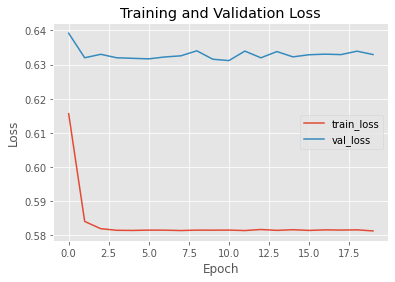

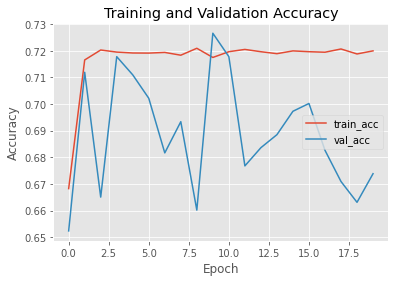

In [ ]:
plot_results_graph(results[:4])

## The test accuracy and loss


In [ ]:
model = results[4]
criterion = nn.BCEWithLogitsLoss()

data_manager = DataManager(batch_size=128)
acc_test, loss_test = evaluate(model, data_manager.get_torch_iterator(TEST), criterion)


In [ ]:
print("Test accuracy is ",acc_test," Test loss is ",loss_test)

Test accuracy is  0.6671401515151515  Test loss is  0.6287311564069358


## Special Subsets

The accuracy over each of the special subsets.
 Those subsets include:
1. Negated polarity – All sentences in the test set where the sentiment polarity
(positive / negative) of one of the main sub-phrases in the sentence is opposite of
the whole sentence sentiment polarity. These are examples where some kind of
negation structure is in effect (as in the examples you saw in the sentiment analysis
lecture). You can use 𝑔𝑒𝑡_𝑛𝑒𝑔𝑎𝑡𝑒𝑑_𝑝𝑜𝑙𝑎𝑟𝑖𝑡𝑦_𝑒𝑥𝑎𝑚𝑝𝑙𝑒𝑠 function to obtain the
indices of those examples from the test set.
2. Rare words – We expect that some of our models will perform better than others on
sentences with unseen or rare words. Therefore, we rank all test sentences by their
maximal frequency of a word which has non-neutral sentiment value and take the
50 sentences ranked lowest. You can use 𝑔𝑒𝑡_𝑟𝑎𝑟𝑒_𝑤𝑜𝑟𝑑𝑠_𝑒𝑥𝑎𝑚𝑝𝑙𝑒𝑠 function to
obtain the indices of those examples from the test set.

In [ ]:
test_sents = dataset.get_test_set()
len(test_sents)

962

In [ ]:
len(data_manager.get_labels(TEST))

962

In [ ]:
words_list = list(data_manager.sentiment_dataset.get_word_counts().keys())
word_to_ind_dct = get_word_to_ind(words_list)

### Negated polarity

In [ ]:
ind = get_negated_polarity_examples(test_sents)

In [ ]:
test_sents_nagated = np.array(test_sents)[ind]
test_labels_nagated = (data_manager.get_labels(TEST))[ind]

In [ ]:
inp = []
labels = []
for i in range(len(test_sents_nagated)):
  inp.append(average_one_hots(test_sents_nagated[i],word_to_ind_dct))
  labels.append(test_labels_nagated[i])

In [ ]:
input_x = torch.tensor(inp)
out = model(input_x)

In [ ]:
prob  =  nn.Sigmoid()(out)
acc_sub = binary_accuracy(prob,labels)
print("Nagated Polarity Accuracy is ",acc_sub)

Nagated Polarity Accuracy is  0.5645161290322581


### Rare words

In [ ]:
senti = SentimentTreeBank()
ind_rare = get_rare_words_examples(test_sents,senti)

In [ ]:
test_sents_rare = np.array(test_sents)[ind_rare]
test_labels_rare = (data_manager.get_labels(TEST))[ind_rare]

In [ ]:
inp_rare = []
labels_rare = []
for i in range(len(test_sents_rare)):
  inp_rare.append(average_one_hots(test_sents_rare[i],word_to_ind_dct))
  labels_rare.append(test_labels_rare[i])

In [ ]:
input_x_rare = torch.tensor(inp_rare)
out_rare = model(input_x_rare)

In [ ]:
prob_rare  =  nn.Sigmoid()(out_rare)
acc_sub_rare = binary_accuracy(prob_rare,labels_rare)
print("Rare words Accuracy is ",acc_sub_rare)

Rare words Accuracy is  0.4


# Building the Word2Vec log-linear model

In order to load these embeddings, we've provided you with the method
𝑐𝑟𝑒𝑎𝑡𝑒_𝑜𝑟_𝑙𝑜𝑎𝑑_𝑠𝑙𝑖𝑚_𝑤2𝑣(). Loading the embeddings might take a considerable amount
of time, that can be spared by saving the dictionary mapping the known words in the corpus
to their embeddings locally.

Implement the
method𝑔𝑒𝑡_𝑤2𝑣_𝑎𝑣𝑒𝑟𝑎𝑔𝑒(𝑠𝑒𝑛𝑡, 𝑤𝑜𝑟𝑑_𝑡𝑜_𝑣𝑒𝑐, 𝑒𝑚𝑏𝑒𝑑𝑑𝑖𝑛𝑔_𝑑𝑖𝑚).
This method returns the average Word2Vec embedding of the given sentence.
(average without the unknowns).

In [ ]:
def get_w2v_average(sent, word_to_vec, embedding_dim):
    """
    This method gets a sentence and returns the average word embedding of the words consisting
    the sentence.
    :param sent: the sentence object
    :param word_to_vec: a dictionary mapping words to their vector embeddings
    :param embedding_dim: the dimension of the word embedding vectors
    :return The average embedding vector as numpy ndarray.
    """
    sum_vec = np.zeros(embedding_dim)
    for word in sent.text:
      if word in word_to_vec.keys():
        sum_vec = sum_vec + word_to_vec[word]
    avg_vec = sum_vec  / len(sent.text)
    return avg_vec

Implement the method 𝑡𝑟𝑎𝑖𝑛_log _𝑙𝑖𝑛𝑒𝑎𝑟_𝑤𝑖𝑡ℎ_𝑤2𝑣(). This method should create all the objects needed for the training process, and run the training process.

Each embedding is a
vector 𝑒 ∈ ℝ300
. Note that not all words in our corpus will have a matching embedding.


In [ ]:
def train_log_linear_with_w2v():
    """
    Here comes your code for training and evaluation of the log linear model with word embeddings
    representation.
    """
    embedding_dim = 300
    data_manager = DataManager(batch_size=64, data_type = W2V_AVERAGE, embedding_dim=embedding_dim)
    embedding_dim = data_manager.get_input_shape()[0]
    model = LogLinear(embedding_dim)
    results = train_model(model, data_manager, n_epochs = 20, lr = 0.01, weight_decay = 0.0001)
    return results

## Results

In [ ]:
w2vec_res = train_log_linear_with_w2v()

Train loss at step 0: 0.4051810950544773
Train accuracy at step 0: 0.8301862212276215
Validation loss at step 0: 0.48106410305927233
Validation accuracy at step 0: 0.78125
******************************************************
Train loss at step 1: 0.367133510623756
Train accuracy at step 1: 0.8463035485933503
Validation loss at step 1: 0.47798528409935265
Validation accuracy at step 1: 0.7763671875
******************************************************
Train loss at step 2: 0.36484118184142117
Train accuracy at step 2: 0.8474896099744246
Validation loss at step 2: 0.47313179126450033
Validation accuracy at step 2: 0.779296875
******************************************************
Train loss at step 3: 0.36437718864649854
Train accuracy at step 3: 0.8474096867007672
Validation loss at step 3: 0.4743247232793023
Validation accuracy at step 3: 0.7763671875
******************************************************
Train loss at step 4: 0.3638314944400665
Train accuracy at step 4: 0.847983535

## Plots

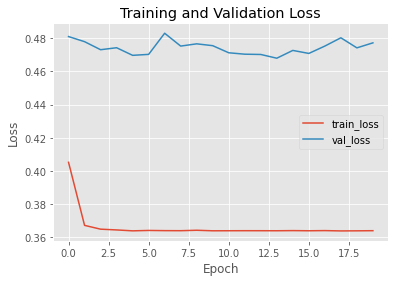

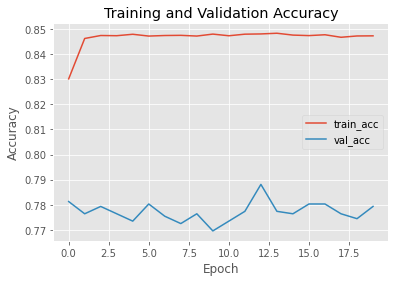

In [ ]:
plot_results_graph(w2vec_res[:4])

## The test accuracy and loss


In [ ]:
w2v_model = w2vec_res[4]
criterion = nn.BCEWithLogitsLoss()
embedding_dim = 300
w2v_data_manager = DataManager(batch_size=64, data_type = W2V_AVERAGE, embedding_dim=embedding_dim)

w2v_acc_test, w2v_loss_test = evaluate(w2v_model, w2v_data_manager.get_torch_iterator(TEST), criterion)


In [ ]:
print("Word2Vec Test accuracy is ",w2v_acc_test," Word2Vec Test loss is ",w2v_loss_test)

Word2Vec Test accuracy is  0.83203125  Word2Vec Test loss is  0.4129860132257997


## Special Subsets

In [ ]:
test_sents = dataset.get_test_set()
words_list = list(w2v_data_manager.sentiment_dataset.get_word_counts().keys())
word_to_vec = create_or_load_slim_w2v(words_list)

### Negated polarity

In [ ]:
ind = get_negated_polarity_examples(test_sents)
test_sents_nagated = np.array(test_sents)[ind]
test_labels_nagated = (w2v_data_manager.get_labels(TEST))[ind]
inp = []
labels = []
for i in range(len(test_sents_nagated)):
  inp.append(get_w2v_average(test_sents_nagated[i],word_to_vec,300))
  labels.append(test_labels_nagated[i])

In [ ]:
input_x = torch.tensor(inp)
out = w2v_model(input_x)

In [ ]:
prob  =  nn.Sigmoid()(out)
acc_sub = binary_accuracy(prob,labels)
print("Word2Vec Nagated Polarity Accuracy is ",acc_sub)

Word2Vec Nagated Polarity Accuracy is  0.5806451612903226


### Rare words

In [ ]:
senti = SentimentTreeBank()
ind_rare = get_rare_words_examples(test_sents,senti)
test_sents_rare = np.array(test_sents)[ind_rare]
test_labels_rare = (w2v_data_manager.get_labels(TEST))[ind_rare]

In [ ]:
inp_rare = []
labels_rare = []
for i in range(len(test_sents_rare)):
  inp_rare.append(get_w2v_average(test_sents_rare[i],word_to_vec,300))
  labels_rare.append(test_labels_rare[i])

In [ ]:
input_x_rare = torch.tensor(inp_rare)
out_rare = w2v_model(input_x_rare)

In [ ]:
prob_rare  =  nn.Sigmoid()(out_rare)
acc_sub_rare = binary_accuracy(prob_rare,labels_rare)
print("Word2Vec Rare words Accuracy is ",acc_sub_rare)

Word2Vec Rare words Accuracy is  0.78


# Building the LSTM model


Implement the class 𝐿𝑆𝑇𝑀. 
We will also use dropout regularization over the input to the linear layer for
training.


In this model, each LSTM cell will receive as input the Word2Vec embedding of a word in the
input sentence. We will then take the two hidden states of the LSTM layer (the last hidden
state of both directions of the bi-LSTM layer) – and concatenate them. Later, we will put this
concatenation through a linear layer and finally output the sigmoid of the result
(representing again 𝑝(𝑦 = 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒|𝑥)) The dimension of the cell and hidden states of the
LSTM will be 100.


In [ ]:
class LSTM(nn.Module):
    """
    An LSTM for sentiment analysis with architecture as described in the exercise description.
    """
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,  bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(in_features=hidden_dim * 2, out_features=1)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        h2 = self.dropout(cat)
        out = self.linear(h2)
        return out

    def predict(self, text):
      out = self.forward(text)
      pred = nn.Sigmoid()(out)
      return pred

Implement the method
𝑠𝑒𝑛𝑡𝑒𝑛𝑐𝑒_𝑡𝑜_𝑒𝑚𝑏𝑒𝑑𝑑𝑖𝑛𝑔(𝑠𝑒𝑛𝑡, 𝑤𝑜𝑟𝑑_𝑡𝑜_𝑣𝑒𝑐, 𝑠𝑒𝑞_𝑙𝑒𝑛, 𝑒𝑚𝑒𝑑𝑑𝑖𝑛𝑔_𝑑𝑖𝑚). This
methods purpose is to map the given sentence to its word embeddings.


*  For all sentences with More than 10 words: we will map each of their first 10 words to their embeddings, and ignore all other words.

*   For all sentences with Less than 10 words: we will map each of their 𝑥 words to their embeddings. These embeddings should be followed by 10 − 𝑥 more 0-vectors, in order to make sure the sentence is of length 10.

*   For all sentences with exactly 10 words: We will map each of its 10 words to its embedding.

In [ ]:
def sentence_to_embedding(sent, word_to_vec, seq_len, embedding_dim=300):
    """
    this method gets a sentence and a word to vector mapping, and returns a list containing the
    words embeddings of the tokens in the sentence.
    :param sent: a sentence object
    :param word_to_vec: a word to vector mapping.
    :param seq_len: the fixed length for which the sentence will be mapped to.
    :param embedding_dim: the dimension of the w2v embedding
    :return: numpy ndarray of shape (seq_len, embedding_dim) with the representation of the sentence
    """
    sent_rep = []
    sent_txt = sent.text
    num_of_words = len(sent_txt)
    num_of_words_dct = 0
    for i in range(num_of_words):
      word = sent_txt[i]
      if i<seq_len and word in word_to_vec.keys():
        num_of_words_dct = num_of_words_dct + 1
        vec = word_to_vec[word]
        sent_rep.append(vec)
    if num_of_words_dct < seq_len:
      l = seq_len - num_of_words_dct
      for i in range(l):
        sent_rep.append(np.zeros(embedding_dim))
    return np.array(sent_rep)

Implement the method 𝑡𝑟𝑎𝑖𝑛_lstm _𝑤𝑖𝑡ℎ_𝑤2𝑣(). This method should create all the
objects needed for the training process, and run the training process.
Train the model once with learning rate 0.001, weight decay value of 0.0001,
dropout probability of 0.5 and the same batch size as before for 4 epochs. 

In [ ]:
def train_lstm_with_w2v():
    """
    Here comes your code for training and evaluation of the LSTM model.
    """
    n_epochs = 4
    batch_size = 64
    lr = 0.001
    weight_decay = 0.0001

    # Model Params
    hidden_dim = 100
    dropout = 0.5

    data_manager = DataManager(batch_size=batch_size, data_type=W2V_SEQUENCE, embedding_dim=300)
    model = LSTM(300, hidden_dim, 1, dropout)
    results = train_model(model, data_manager, n_epochs, lr, weight_decay)
    return results

## Results

### Sequence length is 20

In [ ]:
lstm_seq_20 = train_lstm_with_w2v()

Train loss at step 0: 0.35604295471843755
Train accuracy at step 0: 0.8430754475703325
Validation loss at step 0: 0.5258807306890728
Validation accuracy at step 0: 0.751953125
******************************************************
Train loss at step 1: 0.2932067983803828
Train accuracy at step 1: 0.8746667199488491
Validation loss at step 1: 0.49966859389986135
Validation accuracy at step 1: 0.751953125
******************************************************
Train loss at step 2: 0.26768023990603756
Train accuracy at step 2: 0.8883519820971867
Validation loss at step 2: 0.46525806845161366
Validation accuracy at step 2: 0.7919921875
******************************************************
Train loss at step 3: 0.24567087420250233
Train accuracy at step 3: 0.8995700127877239
Validation loss at step 3: 0.5145324360906942
Validation accuracy at step 3: 0.7822265625
******************************************************


### Sequence length is 32

In [ ]:
lstm_seq_32 = train_lstm_with_w2v()

Train loss at step 0: 0.352086534596786
Train accuracy at step 0: 0.8451270780051151
Validation loss at step 0: 0.49869523934220955
Validation accuracy at step 0: 0.791015625
******************************************************
Train loss at step 1: 0.28696392215414224
Train accuracy at step 1: 0.8805666560102302
Validation loss at step 1: 0.4773885226887768
Validation accuracy at step 1: 0.7998046875
******************************************************
Train loss at step 2: 0.2584168787228665
Train accuracy at step 2: 0.8933895460358057
Validation loss at step 2: 0.47498453172545096
Validation accuracy at step 2: 0.810546875
******************************************************
Train loss at step 3: 0.23628832576772152
Train accuracy at step 3: 0.906891783887468
Validation loss at step 3: 0.522963797164515
Validation accuracy at step 3: 0.7880859375
******************************************************


### Sequence length is 52

In [56]:
lstm_results_52 = train_lstm_with_w2v()

Train loss at step 0: 0.3520374596992698
Train accuracy at step 0: 0.8456841432225064
Validation loss at step 0: 0.4783625059837162
Validation accuracy at step 0: 0.787109375
******************************************************
Train loss at step 1: 0.2865587948044336
Train accuracy at step 1: 0.8804803388746802
Validation loss at step 1: 0.42314603312470245
Validation accuracy at step 1: 0.814453125
******************************************************
Train loss at step 2: 0.2586218493073524
Train accuracy at step 2: 0.8941504156010232
Validation loss at step 2: 0.47259406907007084
Validation accuracy at step 2: 0.8173828125
******************************************************
Train loss at step 3: 0.2351364572024203
Train accuracy at step 3: 0.9052221867007674
Validation loss at step 3: 0.49627036357702003
Validation accuracy at step 3: 0.8115234375
******************************************************


### Sequence Length is 64

In [ ]:
lstm_seq_64 = train_lstm_with_w2v()

Train loss at step 0: 0.3490762190332737
Train accuracy at step 0: 0.8484966432225064
Validation loss at step 0: 0.4513231769745259
Validation accuracy at step 0: 0.7998046875
******************************************************
Train loss at step 1: 0.2840374072997076
Train accuracy at step 1: 0.8807688618925832
Validation loss at step 1: 0.47060095792016127
Validation accuracy at step 1: 0.8125
******************************************************
Train loss at step 2: 0.2571684357515822
Train accuracy at step 2: 0.8950879156010231
Validation loss at step 2: 0.4503984437554597
Validation accuracy at step 2: 0.80859375
******************************************************
Train loss at step 3: 0.23517394110803916
Train accuracy at step 3: 0.9064226342710997
Validation loss at step 3: 0.4519706577353222
Validation accuracy at step 3: 0.8251953125
******************************************************


## Plots

### Sequence length is 20

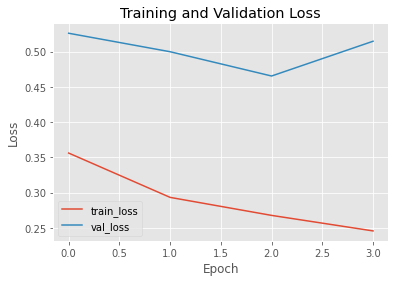

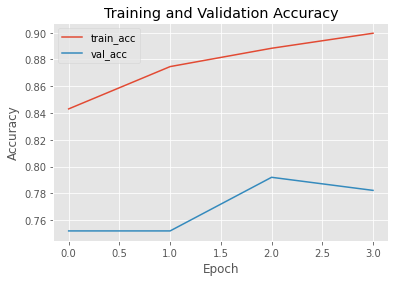

In [ ]:
plot_results_graph(lstm_seq_20[:4])

### Sequence length is 32

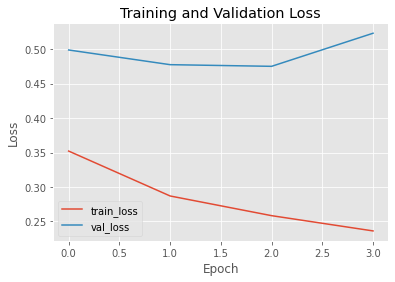

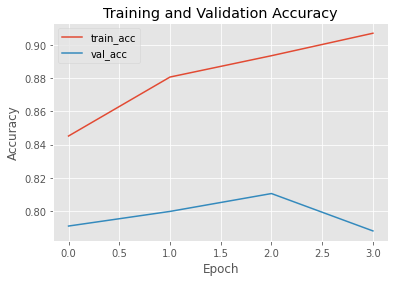

In [65]:
plot_results_graph(lstm_seq_32[:4])

### Sequence length is 52

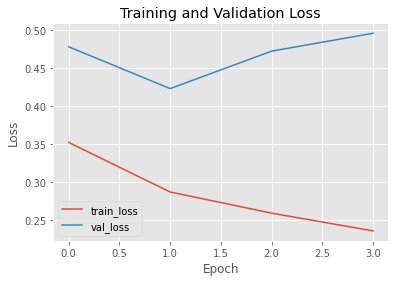

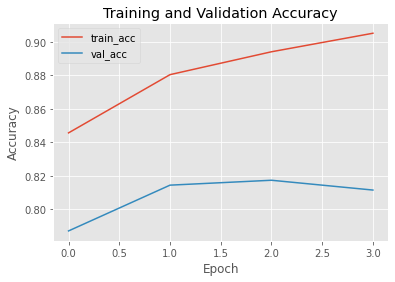

In [59]:
plot_results_graph(lstm_results_52[:4])

### Sequence length is 64

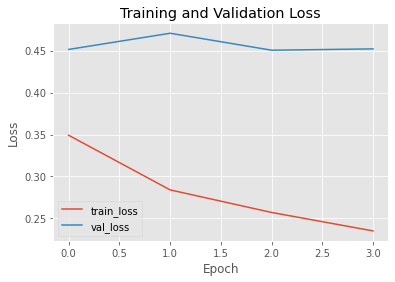

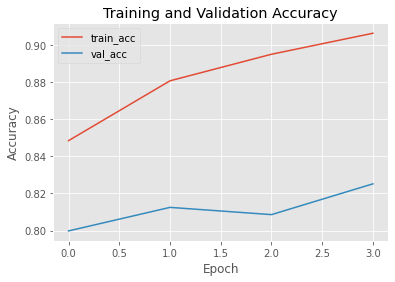

In [66]:
plot_results_graph(lstm_seq_64[:4])

## The test accuracy and loss


In [ ]:
def calc_test_acc(model):
  criterion = nn.BCEWithLogitsLoss()
  embedding_dim = 300
  lstm_data_manager = DataManager(batch_size=64, data_type = W2V_SEQUENCE, embedding_dim=embedding_dim)
  lstm_acc_test, lstm_loss_test = evaluate(lstm_model, lstm_data_manager.get_torch_iterator(TEST), criterion)
  return lstm_acc_test, lstm_loss_test

### Sequence length is 20

In [ ]:
lstm_model = lstm_seq_20[4]
lstm_acc_test, lstm_loss_test = calc_test_acc(lstm_model)
print("LSTM Test accuracy is ",lstm_acc_test," LSTM Test loss is ",lstm_loss_test)

LSTM Test accuracy is  0.859375  LSTM Test loss is  0.32823483225138084


### Sequence length is 32

In [ ]:
lstm_model = lstm_seq_32[4]
lstm_acc_test, lstm_loss_test = calc_test_acc(lstm_model)
print("LSTM Test accuracy is ",lstm_acc_test," LSTM Test loss is ",lstm_loss_test)

LSTM Test accuracy is  0.8671875  LSTM Test loss is  0.34282757189356355


### Sequence length is 52

In [60]:
lstm_model = lstm_results_52[4]
lstm_acc_test, lstm_loss_test = calc_test_acc(lstm_model)

In [61]:
print("LSTM Test accuracy is ",lstm_acc_test," LSTM Test loss is ",lstm_loss_test)

LSTM Test accuracy is  0.8603515625  LSTM Test loss is  0.3571062292517848


### Sequence length is 64

In [ ]:
lstm_model = lstm_seq_64[4]
lstm_acc_test, lstm_loss_test = calc_test_acc(lstm_model)
print("LSTM Test accuracy is ",lstm_acc_test," LSTM Test loss is ",lstm_loss_test)

LSTM Test accuracy is  0.8623046875  LSTM Test loss is  0.3200442953718826


## Special Subsets

In [ ]:
test_sents = dataset.get_test_set()
w2v_data_manager = DataManager(batch_size=64, data_type = W2V_SEQUENCE, embedding_dim=300)
words_list = list(w2v_data_manager.sentiment_dataset.get_word_counts().keys())
word_to_vec = create_or_load_slim_w2v(words_list)

### Negated polarity

In [ ]:
def calc_acc_negated(lstm_model):
  ind = get_negated_polarity_examples(test_sents)
  test_sents_nagated = np.array(test_sents)[ind]
  test_labels_nagated = (w2v_data_manager.get_labels(TEST))[ind]
  inp = []
  labels = []
  for i in range(len(test_sents_nagated)):
    inp.append(sentence_to_embedding(test_sents_nagated[i],word_to_vec,SEQ_LEN))
    labels.append(test_labels_nagated[i])
  input_x = torch.tensor(inp)
  out = lstm_model(input_x)
  prob  =  nn.Sigmoid()(out)
  acc_sub = binary_accuracy(prob,labels)
  print("LSTM Nagated Polarity Accuracy is ",acc_sub)

### Sequence length is 20

In [ ]:
calc_acc_negated(lstm_seq_20[4])

LSTM Nagated Polarity Accuracy is  0.5967741935483871


### Sequence length is 32

In [ ]:
calc_acc_negated(lstm_seq_32[4])

LSTM Nagated Polarity Accuracy is  0.6290322580645161


### Sequence length is 52

In [64]:
calc_acc_negated(lstm_results_52[4])

LSTM Nagated Polarity Accuracy is  0.7096774193548387


### Sequence length is 64

In [ ]:
calc_acc_negated(lstm_seq_64[4])

LSTM Nagated Polarity Accuracy is  0.6774193548387096


### Rare words

In [ ]:
def calc_acc_rare(lstm_model):
  senti = SentimentTreeBank()
  ind_rare = get_rare_words_examples(test_sents,senti)
  test_sents_rare = np.array(test_sents)[ind_rare]
  test_labels_rare = (w2v_data_manager.get_labels(TEST))[ind_rare]
  inp_rare = []
  labels_rare = []
  for i in range(len(test_sents_rare)):
    inp_rare.append(sentence_to_embedding(test_sents_rare[i],word_to_vec,SEQ_LEN))
    labels_rare.append(test_labels_rare[i])
  input_x_rare = torch.tensor(inp_rare)
  out_rare = lstm_model(input_x_rare)
  prob_rare  =  nn.Sigmoid()(out_rare)
  acc_sub_rare = binary_accuracy(prob_rare,labels_rare)
  print("LSTM Rare words Accuracy is ",acc_sub_rare)

### Sequence length is 20

In [ ]:
calc_acc_rare(lstm_seq_20[4])

LSTM Rare words Accuracy is  0.78


### Sequence length is 32

In [ ]:
calc_acc_rare(lstm_seq_32[4])

LSTM Rare words Accuracy is  0.84


### Sequence length is 52

In [58]:
calc_acc_rare(lstm_results_52[4])

LSTM Rare words Accuracy is  0.82


### Sequence length is 64

In [ ]:
calc_acc_rare(lstm_seq_64[4])

LSTM Rare words Accuracy is  0.8


# Comparing the different models

1. Compare the results (test accuracy, validation accuracy) you've received for the
simple log-linear model, and the Word2Vec log-linear model. Which one performs
better? Provide a possible explanation for the results you have.

Test Accuracy 


*   Log-linear model : 0.667
*   Word2Vec Log-linear model : 0.832


Validation Accuracy
*   Log-linear model : 0.674
*   Word2Vec Log-linear model : 0.779

As we can see the Word2Vec model had better performances, it generalizes better when checking accuracy of sentences from the test set and validation set.

The reason that the Word2Vec model has higher accuracy, might be that it can capture contextual word-to-word relationships in a multidimensional space. The vectors that represent the words on the vocabulary are learned by understanding the context in which words appear. The result is vectors in which words with similar meanings end up with a similar numerical representation. 

One-Hot Encoding is unable to recognize semantics of items, while embeddings reflect words similarity patterns by grouping commonly co-occurring items together in the representation space.

Notice that In one hot encoding representation we have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. Therefore all the words are independent of each other.
Using word2vec introduces some dependence of one word on the other words. The words in context of this word would get a greater share of this dependence.



2. Compare the latter results with the results of the LSTM model. Which one performs
better? Provide an explanation for the results you received.

Test Accuracy 


*   Log-linear model : 0.667
*   Word2Vec Log-linear model : 0.832
*   LSTM model : 0.860 


Validation Accuracy
*   Log-linear model : 0.674
*   Word2Vec Log-linear model : 0.779
*   LSTM model : 0.811

As we can see, the LSTM model had the highest accuracy compared to the other models.

A possible explanation is that LSTM models can capture long-term dependencies between word sequences. LSTM learns to keep the relevant content of the sentence and forget the non relevant ones based on training. The hidden state holds information on previous data the network has seen before. It can pass relevant information down the long chain of sequences to make predictions. The idea behind bi-directional networks is to capture information of surrounding inputs.

More specifically, in this task we are requested to predict whether a review is positive or negative. In order to make this decision we need to remember important keywords like : 'amazing' or 'boring'. Those words are more meaningful to understand whether a review is positive or negative than words like 'this' or 'in'.



3. Last, compare the results that all the models had on the 2 special subsets of
sentences we've provided you. For each subset, state the model that has the highest
result (and the lowest result) and provide a possible explanation for these results.

1. Negated Subsets

The model that had the higher results is LSTM
The model that had the lowest results is Log-linear

  *  Log-linear model : 0.564
  *  Word2Vec Log-linear model : 0.581
  *  LSTM model : 0.71

2. Rare words

The model that had the higher results is Word2Vec
The model that had the lowest results is Log-linear

*   Log-linear model : 0.4
*   Word2Vec Log-linear model : 0.78
*   LSTM model : 0.82

Negated polarity - all sentences in the test set where the sentiment polarity
of one of the main sub-phrases in the sentence is opposite of
the whole sentence sentiment polarity. 

The range of the words that are affected by negation words could be different from one sentence to another. For example, in the sentence “The movie was not interesting,” the scope is only the next word after the negation word. But for sentences like “I do not call this film a comedy movie,” the effect of the negation word “not” is until the end of the sentence. The original meaning of the words changes if a positive or negative word falls inside the scope of negation. Moreover, Negation can be explicit or implicit - meaning it carries a negative sentiment, but no negative words are used. Negation can also be morphological where it is either denoted by a prefix (“dis-”, “non-”) or a suffix (“-less”).

Since LSTM remembers the history and learns to keep the relevant content of a sentence, it can identify better negation. In the example we gave it could identify the word 'interesting' as relevant and also the word 'not' so although 'interesting' is a positive word, the word 'not' before it changes the meaning of the whole sentence. Log- linear model that uses one-hot encoder is unable to understand the context of words in sentence, and therefore has poor results.

Rare words - all test sentences ranked by their maximal frequency of a word which has non-neutral sentiment value ,we take the 50 sentences ranked lowest.
 
LSTM has the highest accuracy when using sentences with rare words.
Notice that Word2Vec has also high accuracy, and those results improved by Lstm that uses Word2Vec embedding.
 
Word2Vec is a pre-trained word embedding that can capture the semantic and syntactic meaning of a word as it was trained on large datasets. So Word2Vec generalizes better on rare words.
When using a one-hot encoder we have a problem of sparsity .Most real-world problems contain a dataset that has a large volume of rare words. The vectors learned from these datasets cannot arrive at the right representation of the word. This is why the log-linear model had poor results when testing on rare words.
 
Regarding the LSTM model as we mentioned before, it has the ability to choose the relevant words, so this could be the reason why the results improve a bit compared to Word2Vec alone.